In [ ]:
import os
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
from tqdm import tqdm
import logging
import seaborn as sn

from rsna_dataloader import *


In [13]:
CONFIG = dict(
    n_levels=5,
    backbone="tf_efficientnetv2_b0",
    img_size=(128, 128),
    in_chans=1,
    drop_rate=0.05,
    drop_rate_last=0.3,
    drop_path_rate=0.,
    aug_prob=0.7,
    out_dim=3,
    epochs=200,
    batch_size=8,
    device=torch.device("cuda") if torch.cuda.is_available() else "cpu",
    seed=2024
)


In [14]:
from rsna_dataloader import *
import albumentations
import torchvision.transforms as transforms

data_basepath = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
training_data = retrieve_training_data(data_basepath)

transform_train = albumentations.Compose([
    albumentations.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2),
                                            p=CONFIG["aug_prob"]),
    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=5),
        albumentations.MedianBlur(blur_limit=5),
        albumentations.GaussianBlur(blur_limit=5),
        albumentations.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=CONFIG["aug_prob"]),

    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=1.0),
        albumentations.GridDistortion(num_steps=5, distort_limit=1.),
        albumentations.ElasticTransform(alpha=3),
    ], p=CONFIG["aug_prob"]),

    albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0,
                                    p=CONFIG["aug_prob"]),
    albumentations.Resize(*CONFIG["img_size"]),
    albumentations.CoarseDropout(max_holes=16, max_height=64, max_width=64, min_holes=1, min_height=8, min_width=8,
                                 p=CONFIG["aug_prob"]),
    albumentations.Normalize(mean=0.5, std=0.5),
])

transform_val = albumentations.Compose([
    albumentations.Resize(*CONFIG["img_size"]),
    albumentations.Normalize(mean=0.5, std=0.5),
])



C:\Users\Victor\anaconda3\envs\python-doodles\Lib\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)


In [47]:
import timm

efficientnets = {name: '{:,}'.format(sum(param.numel() for param in timm.create_model(name).parameters())) for name in
                 timm.list_models("*efficientnet*")}

efficientnets

{'efficientnet_b0': '5,288,548',
 'efficientnet_b0_g8_gn': '6,562,660',
 'efficientnet_b0_g16_evos': '8,107,756',
 'efficientnet_b0_gn': '5,288,548',
 'efficientnet_b1': '7,794,184',
 'efficientnet_b1_pruned': '6,331,916',
 'efficientnet_b2': '9,109,994',
 'efficientnet_b2_pruned': '8,309,737',
 'efficientnet_b3': '12,233,232',
 'efficientnet_b3_g8_gn': '14,251,432',
 'efficientnet_b3_gn': '11,733,784',
 'efficientnet_b3_pruned': '9,855,020',
 'efficientnet_b4': '19,341,616',
 'efficientnet_b5': '30,389,784',
 'efficientnet_b6': '43,040,704',
 'efficientnet_b7': '66,347,960',
 'efficientnet_b8': '87,413,142',
 'efficientnet_blur_b0': '5,288,548',
 'efficientnet_cc_b0_4e': '13,314,116',
 'efficientnet_cc_b0_8e': '24,013,284',
 'efficientnet_cc_b1_8e': '39,715,968',
 'efficientnet_el': '10,589,712',
 'efficientnet_el_pruned': '10,589,712',
 'efficientnet_em': '6,899,496',
 'efficientnet_es': '5,438,392',
 'efficientnet_es_pruned': '5,438,392',
 'efficientnet_h_b5': '45,884,172',
 'effici

In [26]:
import timm

support_512 = {name: '{:,}'.format(sum(param.numel() for param in timm.create_model(name).parameters())) for name in
               timm.list_models("*512*")}

support_512

{'beit_large_patch16_512': '305,674,728',
 'levit_512': '95,173,700',
 'levit_512_s8': '74,046,696',
 'levit_512d': '92,497,538',
 'levit_conv_512': '95,173,700',
 'levit_conv_512_s8': '74,046,696',
 'levit_conv_512d': '92,497,538',
 'maxvit_base_tf_512': '119,876,380',
 'maxvit_large_tf_512': '212,330,456',
 'maxvit_small_tf_512': '69,127,540',
 'maxvit_tiny_tf_512': '31,049,584',
 'maxvit_xlarge_tf_512': '475,769,296',
 'tiny_vit_21m_512': '21,268,120',
 'vit_base_patch16_siglip_512': '93,520,128',
 'vit_base_patch16_siglip_gap_512': '86,433,024',
 'volo_d5_512': '296,091,488'}

In [5]:
import timm

efficientvits = {name: '{:,}'.format(sum(param.numel() for param in timm.create_model(name).parameters())) for name in
                 timm.list_models("*efficientvit*")}
deits = {name: '{:,}'.format(sum(param.numel() for param in timm.create_model(name).parameters())) for name in
                 timm.list_models("*deit*")}
beits = {name: '{:,}'.format(sum(param.numel() for param in timm.create_model(name).parameters())) for name in
                 timm.list_models("*beit*")}
dinos = {name: '{:,}'.format(sum(param.numel() for param in timm.create_model(name).parameters())) for name in
                 timm.list_models("*dino*")}
maes = {name: '{:,}'.format(sum(param.numel() for param in timm.create_model(name).parameters())) for name in
                 timm.list_models("*mae*")}


efficientvits, deits, beits, dinos, maes

({'efficientvit_b0': '3,410,008',
  'efficientvit_b1': '9,102,024',
  'efficientvit_b2': '24,330,712',
  'efficientvit_b3': '48,646,056',
  'efficientvit_l1': '52,654,088',
  'efficientvit_l2': '63,707,016',
  'efficientvit_l3': '246,037,288',
  'efficientvit_m0': '2,349,436',
  'efficientvit_m1': '2,980,560',
  'efficientvit_m2': '4,187,554',
  'efficientvit_m3': '6,900,722',
  'efficientvit_m4': '8,804,228',
  'efficientvit_m5': '12,473,772'},
 {'deit3_base_patch16_224': '86,585,320',
  'deit3_base_patch16_384': '86,877,160',
  'deit3_huge_patch14_224': '632,126,440',
  'deit3_large_patch16_224': '304,374,760',
  'deit3_large_patch16_384': '304,763,880',
  'deit3_medium_patch16_224': '38,849,512',
  'deit3_small_patch16_224': '22,059,496',
  'deit3_small_patch16_384': '22,205,416',
  'deit_base_distilled_patch16_224': '87,338,192',
  'deit_base_distilled_patch16_384': '87,630,032',
  'deit_base_patch16_224': '86,567,656',
  'deit_base_patch16_384': '86,859,496',
  'deit_small_distill

In [38]:
import timm

densenets = {name: '{:,}'.format(sum(param.numel() for param in timm.create_model(name).parameters())) for name in
                 timm.list_models("*dense*")}
inceptions = {name: '{:,}'.format(sum(param.numel() for param in timm.create_model(name).parameters())) for name in
                 timm.list_models("*inception*")}
resnets = {name: '{:,}'.format(sum(param.numel() for param in timm.create_model(name).parameters())) for name in
                 timm.list_models("*resnet*")}
resnexts = {name: '{:,}'.format(sum(param.numel() for param in timm.create_model(name).parameters())) for name in
                 timm.list_models("*resnext*")}

densenets, inceptions, resnets, resnexts

({'densenet121': '7,978,856',
  'densenet161': '28,681,000',
  'densenet169': '14,149,480',
  'densenet201': '20,013,928',
  'densenet264d': '72,736,216',
  'densenetblur121d': '7,998,088'},
 {'inception_next_base': '86,672,136',
  'inception_next_small': '49,374,016',
  'inception_next_tiny': '28,055,680',
  'inception_resnet_v2': '55,843,464',
  'inception_v3': '23,834,568',
  'inception_v4': '42,679,816'},
 {'cspresnet50': '21,616,168',
  'cspresnet50d': '21,635,400',
  'cspresnet50w': '28,118,216',
  'eca_resnet33ts': '19,676,302',
  'ecaresnet26t': '16,011,916',
  'ecaresnet50d': '25,576,350',
  'ecaresnet50d_pruned': '19,939,713',
  'ecaresnet50t': '25,573,814',
  'ecaresnet101d': '44,568,563',
  'ecaresnet101d_pruned': '24,876,040',
  'ecaresnet200d': '64,693,400',
  'ecaresnet269d': '102,093,077',
  'ecaresnetlight': '30,162,046',
  'gcresnet33ts': '19,880,698',
  'gcresnet50t': '25,897,080',
  'inception_resnet_v2': '55,843,464',
  'lambda_resnet26rpt_256': '10,988,688',
  'la

In [32]:
import timm_3d

efficientnets_ = {name: '{:,}'.format(sum(param.numel() for param in timm_3d.create_model(name).parameters())) for name
                 in timm_3d.list_models("*efficientnet*") if "pruned" not in name}
vits_ = {name: '{:,}'.format(sum(param.numel() for param in timm_3d.create_model(name).parameters())) for name in
        timm_3d.list_models("*vit*")}
deits_ = {name: '{:,}'.format(sum(param.numel() for param in timm_3d.create_model(name).parameters())) for name in
        timm_3d.list_models("*deit*")}
maes_ = {name: '{:,}'.format(sum(param.numel() for param in timm_3d.create_model(name).parameters())) for name in
        timm_3d.list_models("*mae*")}
beits_ = {name: '{:,}'.format(sum(param.numel() for param in timm_3d.create_model(name).parameters())) for name in
        timm_3d.list_models("*beit*")}
dinos_ = {name: '{:,}'.format(sum(param.numel() for param in timm_3d.create_model(name).parameters())) for name in
        timm_3d.list_models("*dino*")}

efficientnets_, vits_, deits_, beits_, dinos_, maes_

C:\Users\Victor\anaconda3\envs\python-doodles\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


({'efficientnet_b0': '5,971,108',
  'efficientnet_b0_g8_gn': '12,011,044',
  'efficientnet_b0_g16_evos': '19,184,044',
  'efficientnet_b0_gn': '5,971,108',
  'efficientnet_b1': '8,729,224',
  'efficientnet_b2': '10,125,674',
  'efficientnet_b3': '13,597,632',
  'efficientnet_b3_g8_gn': '24,770,248',
  'efficientnet_b3_gn': '13,050,904',
  'efficientnet_b4': '21,408,352',
  'efficientnet_b5': '33,100,056',
  'efficientnet_b6': '46,699,552',
  'efficientnet_b7': '71,323,448',
  'efficientnet_b8': '93,646,518',
  'efficientnet_cc_b0_4e': '15,844,484',
  'efficientnet_cc_b0_8e': '29,007,396',
  'efficientnet_cc_b1_8e': '46,481,280',
  'efficientnet_el': '15,742,336',
  'efficientnet_em': '10,232,808',
  'efficientnet_es': '7,905,400',
  'efficientnet_l2': '498,169,196',
  'efficientnet_lite0': '5,334,568',
  'efficientnet_lite1': '6,316,872',
  'efficientnet_lite2': '7,069,448',
  'efficientnet_lite3': '9,519,016',
  'efficientnet_lite4': '15,023,336',
  'efficientnetv2_l': '126,773,384',


In [2]:
import timm_3d

densenets = {name: '{:,}'.format(sum(param.numel() for param in timm_3d.create_model(name).parameters())) for name
                 in timm_3d.list_models("*densenet*") if "pruned" not in name}
inceptions = {name: '{:,}'.format(sum(param.numel() for param in timm_3d.create_model(name).parameters())) for name
                 in timm_3d.list_models("*inception*") if "pruned" not in name}

densenets, inceptions

({'densenet121': '12,311,528',
  'densenet161': '41,704,936',
  'densenet169': '20,251,624',
  'densenet201': '27,295,720',
  'densenet264d': '94,428,664',
  'densenetblur121d': '12,331,336'},
 {})

In [ ]:
import timm_3d

timm_3d.list_models()

In [ ]:
import timm_3d

maes_3d = {name: '{:,}'.format(sum(param.numel() for param in timm_3d.create_model(name).parameters())) for name in timm_3d.list_models("*mae*")}

maes_3d

In [3]:
from torchvision.transforms import Resize, Compose, ToPILImage
from rsna_dataloader import *

data_basepath = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
training_data = retrieve_training_data(data_basepath)

trainloader, valloader, testloader, trainset, valset, testset = create_series_level_datasets_and_loaders(training_data,
                                                                                                         "Sagittal T2/STIR",
                                                                                                         transform_train,
                                                                                                         transform_val,
                                                                                                         base_path=os.path.join(
                                                                                                             data_basepath,
                                                                                                             "train_images"),
                                                                                                         split_factor=0.3,
                                                                                                         num_workers=0,
                                                                                                         batch_size=1,
                                                                                                         data_type=SeriesDataType.SEQUENTIAL_VARIABLE_LENGTH_WITH_CLS)

In [8]:
trainset[0][0].shape

(38, 384, 384)

In [5]:
import torch
from torch import nn

class CNN_Model(nn.Module):
    def __init__(self, backbone="tf_efficientnetv2_b3", pretrained=False):
        super(CNN_Model, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            num_classes=CONFIG["out_dim"] * CONFIG["n_levels"],
            features_only=False,
            drop_rate=CONFIG["drop_rate"],
            drop_path_rate=CONFIG["drop_path_rate"],
            pretrained=pretrained,
            in_chans=CONFIG["in_chans"],
        )

    def forward(self, x):
        return self.encoder(x).reshape((-1, 5, 3))


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        pos_emb = self.pe[:x.size(0)]
        x = x + pos_emb
        return self.dropout(x)


class EfficientNetModel_Series(nn.Module):
    def __init__(self, backbone: CNN_Model, num_inter_layers=4):
        super(EfficientNetModel_Series, self).__init__()

        self.backbone = backbone
        self.backbone.encoder.classifier = nn.Identity()
        self.backbone.forward = self._backbone_forward
        self.num_inter_layers = num_inter_layers

        hdim = self.backbone.encoder.conv_head.out_channels
        self.pos_emb = PositionalEncoding(d_model=hdim, dropout=CONFIG["drop_rate"])
        self.attention_layer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hdim, nhead=8, dropout=CONFIG["drop_rate"]),
            num_layers=self.num_inter_layers,
            norm=nn.LayerNorm(hdim, eps=1e-05, elementwise_affine=True)
        )
        self.head = NormMLPClassifierHead(hdim, CONFIG["n_levels"] * CONFIG["out_dim"])

    def _backbone_forward(self, x):
        return self.backbone.encoder(x)

    def forward(self, x):
        feat = self.backbone(x.squeeze(0).unsqueeze(1))
        feat = feat.unsqueeze(0)

        feat = self.pos_emb(feat)
        feat = self.attention_layer(feat)

        feat = self.head(feat[:, 0])

        return feat.reshape((-1, CONFIG["n_levels"], CONFIG["out_dim"]))

class NormMLPClassifierHead(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(NormMLPClassifierHead, self).__init__()

        self.out_dim = out_dim
        self.head = nn.Sequential(
            nn.LayerNorm(in_dim, eps=1e-05, elementwise_affine=True),
            # nn.Flatten(start_dim=1, end_dim=-1),
            nn.Dropout(p=CONFIG["drop_rate_last"], inplace=True),
            nn.Linear(in_features=in_dim, out_features=out_dim, bias=True),
            # nn.Softmax()
        )

    def forward(self, x):
        return self.head(x)

In [11]:
class CNN_Model_Multichannel(nn.Module):
    def __init__(self, backbone="tf_efficientnetv2_b3", pretrained=False):
        super(CNN_Model_Multichannel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            num_classes=CONFIG["out_dim"] * CONFIG["n_levels"],
            features_only=False,
            drop_rate=CONFIG["drop_rate"],
            drop_path_rate=CONFIG["drop_path_rate"],
            pretrained=pretrained,
            # !TODO: Refactor
            in_chans=CONFIG["in_chans"] * 38,
        )

    def forward(self, x):
        return self.encoder(x).reshape((-1, 5, 3))

In [18]:
class CNN_Model_3D(nn.Module):
    def __init__(self, backbone="efficientnet_lite0", in_chans=1, out_classes=5, pretrained=True):
        super(CNN_Model_3D, self).__init__()
        self.out_classes = out_classes

        self.encoder = timm_3d.create_model(
            backbone,
            num_classes=out_classes * CONFIG["out_dim"],
            features_only=False,
            drop_rate=CONFIG["drop_rate"],
            drop_path_rate=CONFIG["drop_path_rate"],
            pretrained=pretrained,
            in_chans=in_chans,
        ).to(CONFIG["device"])

    def forward(self, x):
        # return self.encoder(x).reshape((-1, self.out_classes, 3))
        return self.encoder(x)

In [19]:
import torch

series_inference_model = torch.load("../models\\efficientnet_b0_128_3d_neg_vs_pos_weighted_bce\\efficientnet_b0_128_3d_neg_vs_pos_weighted_bce_10.pt")
series_inference_model.eval()

CNN_Model_3D(
  (encoder): EfficientNet(
    (conv_stem): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (bn1): BatchNormAct3d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
          (bn1): BatchNormAct3d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv3d(32, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv3d(8, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
            (gate): Sigmoid()
          )
          (conv_pw)

In [15]:
DATA_BASEPATH = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
TRAINING_DATA = retrieve_coordinate_training_data(DATA_BASEPATH)

(trainloader, valloader, test_loader,
 trainset, valset, testset) = create_subject_level_datasets_and_loaders(TRAINING_DATA,
                                                                        transform_train,
                                                                        transform_val,
                                                                        transform_3d_train=None,
                                                                        base_path=os.path.join(
                                                                           DATA_BASEPATH,
                                                                           "train_images"),
                                                                        num_workers=0,
                                                                        split_factor=0.3,
                                                                        batch_size=8,
                                                                        data_type=SeriesDataType.CUBE_3D_DOWNSAMPLED_PADDED)


C:\Users\Victor\Documents\python-doodles\rsna-2024\rsna_dataloader.py:775: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  filtered_df = pd.concat([filtered_df, subset])


In [16]:
testset[0][0].shape

torch.Size([3, 128, 128, 128])

In [20]:
from tqdm import tqdm

inferred = []
target = []

with torch.no_grad():
    for image, label in tqdm(test_loader):
        target.append(label.detach())
        inferred.append(series_inference_model(image.to("cuda")).detach())


100%|██████████| 17/17 [01:45<00:00,  6.20s/it]


In [21]:
import torch.nn as nn

inferred_new = []
target_new = []
for e in inferred:
    for elem in e:
        inferred_new.append(elem.reshape((-1, 25, 3)))
for e in target:
    for elem in e:
        target_new.append(elem.reshape((-1, 25, 3)))
        
        
nn.Softmax(dim=2)(inferred_new[1]), target_new[1]

(tensor([[[0.2013, 0.6179, 0.1808],
          [0.1267, 0.4096, 0.4637],
          [0.2322, 0.3921, 0.3756],
          [0.2461, 0.3455, 0.4084],
          [0.2092, 0.4555, 0.3353],
          [0.1592, 0.5171, 0.3237],
          [0.1959, 0.3798, 0.4243],
          [0.2152, 0.3622, 0.4226],
          [0.2311, 0.3381, 0.4308],
          [0.2479, 0.3493, 0.4027],
          [0.1245, 0.3894, 0.4861],
          [0.1711, 0.4632, 0.3657],
          [0.2238, 0.4505, 0.3257],
          [0.2343, 0.4241, 0.3416],
          [0.2057, 0.4175, 0.3767],
          [0.1254, 0.5057, 0.3689],
          [0.1450, 0.4555, 0.3995],
          [0.2036, 0.3573, 0.4391],
          [0.1975, 0.3995, 0.4030],
          [0.2438, 0.3514, 0.4047],
          [0.1605, 0.3370, 0.5026],
          [0.1845, 0.4077, 0.4077],
          [0.1854, 0.4621, 0.3525],
          [0.2245, 0.3975, 0.3781],
          [0.2761, 0.4779, 0.2460]]], device='cuda:0'),
 tensor([[[1., 0., 0.],
          [0., 1., 0.],
          [0., 1., 0.],
        

In [22]:
inferred_l = [[np.argmax(e_) for e_ in e.detach().cpu()[0]] for e in inferred_new]
target_l = [[np.argmax(e_) for e_ in e.detach().cpu()[0]] for e in target_new]

In [23]:
len(inferred_l[1]), len(target_l[1])

(25, 25)

In [7]:
train_labels = list(trainset.labels.values())
train_labels = [e.reshape(-1, 25, 3)[0] for e in train_labels]
train_labels[0]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [12]:
train_df = pd.DataFrame([np.argmax(e, axis=1) for e in train_labels])
relative_weights = []
for i in range(25):
    curr_gr = train_df.groupby(i).count().values[:,0]
    curr_gr = (sum(curr_gr) - curr_gr) / curr_gr
    relative_weights.append(list(curr_gr))
relative_weights = np.array(relative_weights)
list(relative_weights)

[array([  1.03574397,  30.3902439 , 623.        ]),
 array([  1.10265487,  11.53703704, 155.75      ]),
 array([ 1.29656608,  4.73764259, 56.63636364]),
 array([ 1.65033113,  3.12280702, 13.54347826]),
 array([1.60981912, 3.73053892, 9.02898551]),
 array([ 1.06678082, 20.76666667, 69.22222222]),
 array([ 1.21206226,  7.64417178, 22.65454545]),
 array([ 1.47630332,  4.31141869, 11.02654867]),
 array([2.15944541, 3.27034121, 4.32638889]),
 array([ 1.39686099,  4.79230769, 13.25531915]),
 array([  1.04442582,  28.31818182, 138.44444444]),
 array([  1.09876543,  11.53703704, 311.5       ]),
 array([ 1.30198537,  4.75572519, 46.14814815]),
 array([ 1.60154242,  3.28759894, 14.        ]),
 array([ 1.50847458,  4.15333333, 10.38333333]),
 array([ 1.08065915, 15.7721519 , 89.        ]),
 array([ 1.20038536,  7.59756098, 28.31818182]),
 array([ 1.48333333,  4.1952862 , 11.43119266]),
 array([2.21708185, 3.17857143, 4.26712329]),
 array([ 1.4       ,  5.00401606, 11.64485981]),
 array([ 1.046179

In [87]:
train_df.groupby(1).count()

array([1130,  108,    8], dtype=int64)

In [67]:
train_df.groupby(1).count()

,0,2,3,4
1,,,,
0,888,888,888,888
1,199,199,199,199
2,294,294,294,294


In [68]:
train_df.groupby(2).count()

,0,1,3,4
2,,,,
0,719,719,719,719
1,383,383,383,383
2,279,279,279,279


In [69]:
train_df.groupby(3).count()


,0,1,2,4
3,,,,
0,603,603,603,603
1,323,323,323,323
2,455,455,455,455


In [70]:
train_df.groupby(4).count()


,0,1,2,3
4,,,,
0,969,969,969,969
1,202,202,202,202
2,210,210,210,210


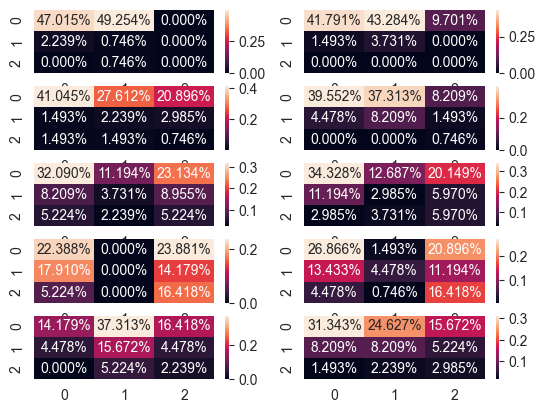

In [24]:
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix
from operator import truediv

precisions_l = []
recalls_l = []

precisions_r = []
recalls_r = []

# !TODO: Refactor
fig, ax = plt.subplots(nrows=5, ncols=2)
for i in range(5):
    target_ = [e[i + 5] for e in target_l]
    inferred_ = [e[i + 5] for e in inferred_l]

    cf_matrix = confusion_matrix(target_, inferred_)
    sn.heatmap(cf_matrix / (np.sum(cf_matrix) + 1e-7), ax=ax[i][0], annot=True, fmt='.3%')

    true_pos = np.diag(cf_matrix)
    prec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=0) + 1e-7))
    rec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=1) + 1e-7))
    
    precisions_l.append(prec)
    recalls_l.append(rec)

    target_ = [e[i + 15] for e in target_l]
    inferred_ = [e[i + 15] for e in inferred_l]

    cf_matrix = confusion_matrix(target_, inferred_)
    sn.heatmap(cf_matrix / (np.sum(cf_matrix) + 1e-7), ax=ax[i][1], annot=True, fmt='.3%')

    true_pos = np.diag(cf_matrix)
    prec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=0) + 1e-7))
    rec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=1) + 1e-7))
    
    precisions_r.append(prec)
    recalls_r.append(rec)

plt.show()


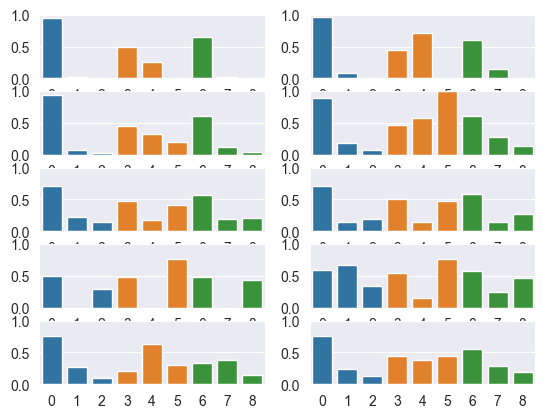

In [26]:
fig, ax = plt.subplots(nrows=5, ncols=2)
plt.set_loglevel('WARNING')
for i in range(5):
    ax[i][0].set(ylim=(0, 1))
    sn.barplot(x=range(3), y=precisions_l[i], ax=ax[i][0])
    sn.barplot(x=range(3, 6), y=recalls_l[i], ax=ax[i][0])
    sn.barplot(x=range(6, 9), y=2 / (1 / (np.array(recalls_l[i]) + 1e-7) + 1 / (np.array(precisions_l[i]) + 1e-7)), ax=ax[i][0])

    ax[i][1].set(ylim=(0, 1))
    sn.barplot(x=range(3), y=precisions_r[i], ax=ax[i][1])
    sn.barplot(x=range(3, 6), y=recalls_r[i], ax=ax[i][1])
    sn.barplot(x=range(6, 9), y=2 / (1 / (np.array(recalls_r[i]) + 1e-7) + 1 / (np.array(precisions_r[i]) + 1e-7)), ax=ax[i][1])

plt.show()


In [4]:
resized_example = np.array([[Resize((256,256))(ToPILImage()(img)) for img in trainset[i][0]][:16] * 16 for i in range(2)])
resized_example = resized_example.swapaxes(1, 3).swapaxes(1, 2)

In [6]:
# B, C, H, W, D
torch.Tensor(resized_example).unsqueeze(1).shape

torch.Size([2, 1, 256, 256, 16])

In [9]:
import timm_3d

test_3d_model = timm_3d.create_model("maxvit_nano_rw_256", in_chans=1).to("cuda")

out = test_3d_model(torch.Tensor(resized_example).unsqueeze(1).to("cuda"))
out

C:\Users\Victor\anaconda3\envs\python-doodles\Lib\site-packages\timm_3d\models\maxxvit.py:275: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = torch.nn.functional.scaled_dot_product_attention(


tensor([[-0.2116,  0.4472, -0.2582,  ...,  0.0735,  0.1997,  0.1392],
        [-0.5368, -0.3499, -0.0473,  ..., -0.1650,  0.2508, -0.4454]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [10]:
del out
torch.cuda.empty_cache()

In [5]:
import timm_3d

test_3d_model_2 = timm_3d.create_model("tf_efficientnet_b0", in_chans=1).to("cuda")

test_3d_model_2(torch.Tensor(resized_example).unsqueeze(1).to("cuda"))

tensor([[-0.0668, -0.0082,  0.0799,  ...,  0.2645,  0.2260, -0.1619],
        [ 0.0260,  0.0702, -0.0215,  ..., -0.0607,  0.0993, -0.0696]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [2]:
import albumentations as A
from rsna_dataloader import *

data_basepath = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
training_data = retrieve_training_data(data_basepath)

training_data = training_data.dropna()

training_data = training_data[training_data.groupby(["study_id", "series_description"]).transform('size') == 25]
testset = PatientLevelDataset(os.path.join(data_basepath, "train_images"), training_data, transform=A.Resize(128,128))
testset[1][0].shape, testset[1][1].shape

(torch.Size([3, 128, 128, 128]), torch.Size([75]))

In [3]:
testset[2][0].shape

NameError: name 'testset' is not defined